<a href="https://colab.research.google.com/github/trodrigue1304/Fraud_detection_algorithm/blob/Med/source.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Chargement des données et paramétrage de l'environnement de travail**

In [ ]:
# Chargement des packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import sklearn as skl
import seaborn as sns
from google.colab import drive
from sklearn.impute import KNNImputer

# Connexion à google drive et importation des données
drive.mount('/content/drive')
id_train=pd.read_csv('/content/drive/My Drive/projet python/train_identity.csv')
tr_train=pd.read_csv('/content/drive/My Drive/projet python/train_transaction.csv')
id_test=pd.read_csv('/content/drive/My Drive/projet python/test_identity.csv')
tr_test=pd.read_csv('/content/drive/My Drive/projet python/test_transaction.csv')

## Affichage de toutes les lignes pour les outputs
pd.options.display.max_rows = 4000

Mounted at /content/drive


### **Première exploration des données**

**Visualisation des données**

In [ ]:
id_train.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [ ]:
tr_train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,debit,272.0,87.0,36.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,debit,126.0,87.0,0.0,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,debit,325.0,87.0,NaN,NaN,mail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,debit,204.0,87.0,19.0,NaN,yahoo.com,NaN,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,1.0,0.0,12.0,2.0,61.0,61.0,30.0,318.0,30.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,495.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#verifier que toutes les TransactionID de id_train existe dans tr_train
print("Taille de la base identity : ",id_train.shape)
print("Taille de la base transaction : ",tr_train.shape)
print("Nombre de transactions uniques de la base transaction : ",id_train['TransactionID'].nunique())
print("Nombre de transactions uniques de la base identity : ",tr_train['TransactionID'].nunique())
print("Proportion de transactions avec id information (train): "+"{:.2%}".format(np.sum(tr_train['TransactionID'].isin(id_train['TransactionID'].unique()))/tr_train['TransactionID'].nunique()))
print("Proportion de transactions avec id information (test): "+"{:.2%}".format(np.sum(tr_test['TransactionID'].isin(id_test['TransactionID'].unique()))/tr_test['TransactionID'].nunique()))

Taille de la base identity :  (144233, 41)
Taille de la base transaction :  (590540, 394)
Nombre de transactions uniques de la base transaction :  144233
Nombre de transactions uniques de la base identity :  590540
Proportion de transactions avec id information (train): 24.42%
Proportion de transactions avec id information (test): 28.01%


On remarque qu'il y a des transactions sans informations d'identification. On ne tiendra pas compte de ces données.

**Fusion des bases de données**

In [ ]:
train=pd.merge(tr_train,id_train,on="TransactionID",how="right")
test=pd.merge(tr_test,id_test,on="TransactionID",how="right")

**Type des variables**

In [ ]:
train.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
C14               float64
D1                float64
D2                float64
D3                float64
D4                float64
D5                float64
D6                float64
D7                float64
D8          

**Détection des valeurs manquantes**

In [ ]:
missing_data=train.isnull().sum().sum()
total_data=np.product(train.shape)
print("Proportion de données manquantes dans la base : "+"{:.2%}".format(missing_data/total_data))

Proportion de données manquantes dans la base : 26.89%


In [ ]:
#Fonction pour la visualition de la répartition des données manquantes
def missing_view(data) :
  null_counts = data.isnull().sum()/len(data)
  plt.figure(figsize=(100,20))
  plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical')
  plt.ylabel('Proportion de données manquantes')
  plt.bar(np.arange(len(null_counts)),null_counts)


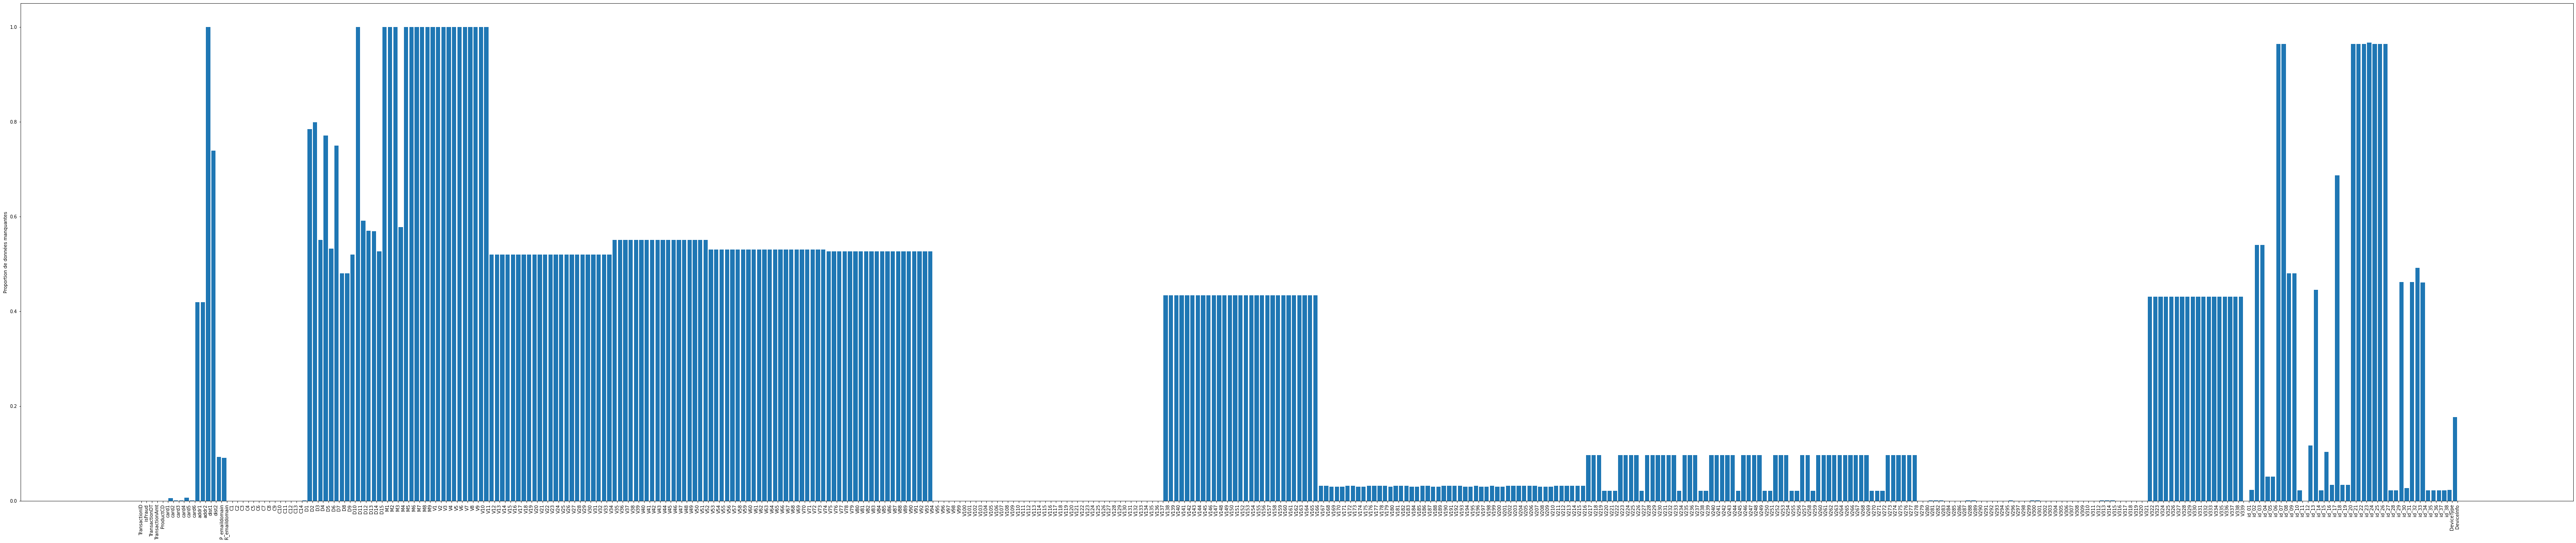

In [ ]:
#Visualisation
missing_view(train)

Il faudra donc procéder à un traitement des valeurs manquantes et s'il le faut voir l'impact sur les modèles futurs.

**Analyse de la variable d'intérêt**

In [ ]:
#Tableau des effectifs
tab = pd.DataFrame(train.groupby('isFraud').count()['TransactionID'])
tab

,TransactionID
isFraud,
0,132915
1,11318


Text(0.5, 1.0, 'Distribution de la variable isFraud')

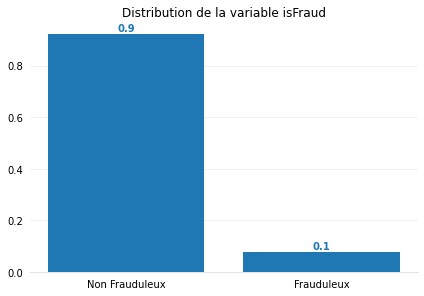

In [ ]:
#Visualisation
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

# Axis formatting.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# Grab the color of the bars so we can make the
# text the same color.
bar_color = bars[0].get_facecolor()

# Add text annotations to the top of the bars.
# Note, you'll have to adjust this slightly (the 0.3)
# with different data.
for bar in bars:
  ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + 0.01,
      round(bar.get_height(), 1),
      horizontalalignment='center',
      color=bar_color,
      weight='bold'
  )

fig.tight_layout()

ax.set_title("Distribution de la variable isFraud")

  On soupçonne un surapprentissage des modèles sur les valeurs non frauduleuses. On recalibre les données de manière à avoir une répartition uniforme.

In [ ]:
#Recalibrage
class0=np.where(train['isFraud']==0)[0]
class1=np.where(train['isFraud']==1)[0]
class0_downsample=np.random.choice(class0,size=len(class1),replace=False)
Kept_index=sorted([*class0_downsample,*class1])
train_calibrate=train[train.index.isin(Kept_index)]

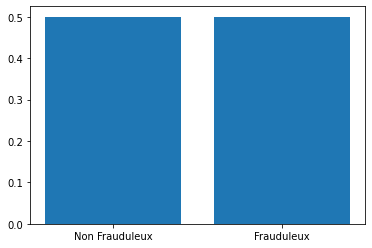

In [ ]:
#On s'assure que le tirage a été bien fait
tab = pd.DataFrame(train_calibrate.groupby('isFraud').count()['TransactionID'])
tab['TransactionID'] = tab['TransactionID']/tab['TransactionID'].sum()
fig, ax = plt.subplots()

# Save the chart so we can loop through the bars below.
bars = ax.bar(
    x=np.arange(tab.size),
    height=tab['TransactionID'],
    tick_label=['Non Frauduleux', 'Frauduleux']
)

**Visualisation des données manquantes dans la base recalibré**

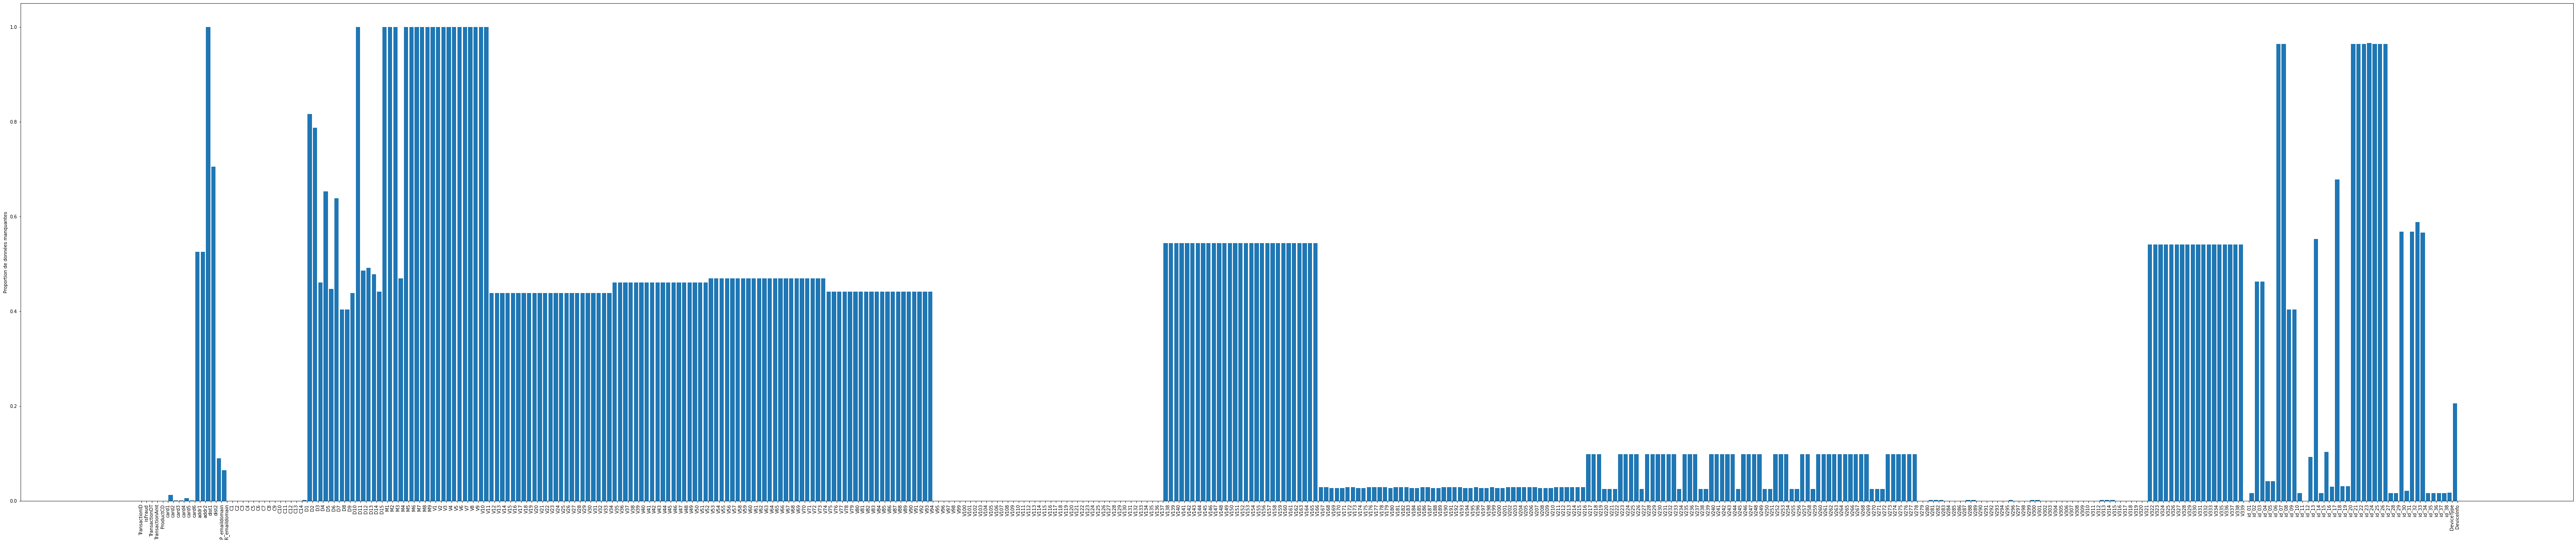

In [ ]:
missing_view(train_calibrate)

On remarque que la distribution est quasiment la même avec celle obtenue avant. 
Conclusion : Les données recalibrées sont à l'image des données initiale sur ce plan. On peut donc se restreindre à la nouvelle base pour la suite des travaux.

### **Analyse et traitement des données manquantes**

**Valeurs manquantes suivant la variable d'intérêt**

Text(0.5, 0.98, 'Valeurs manquantes sur les données frauduleuses')

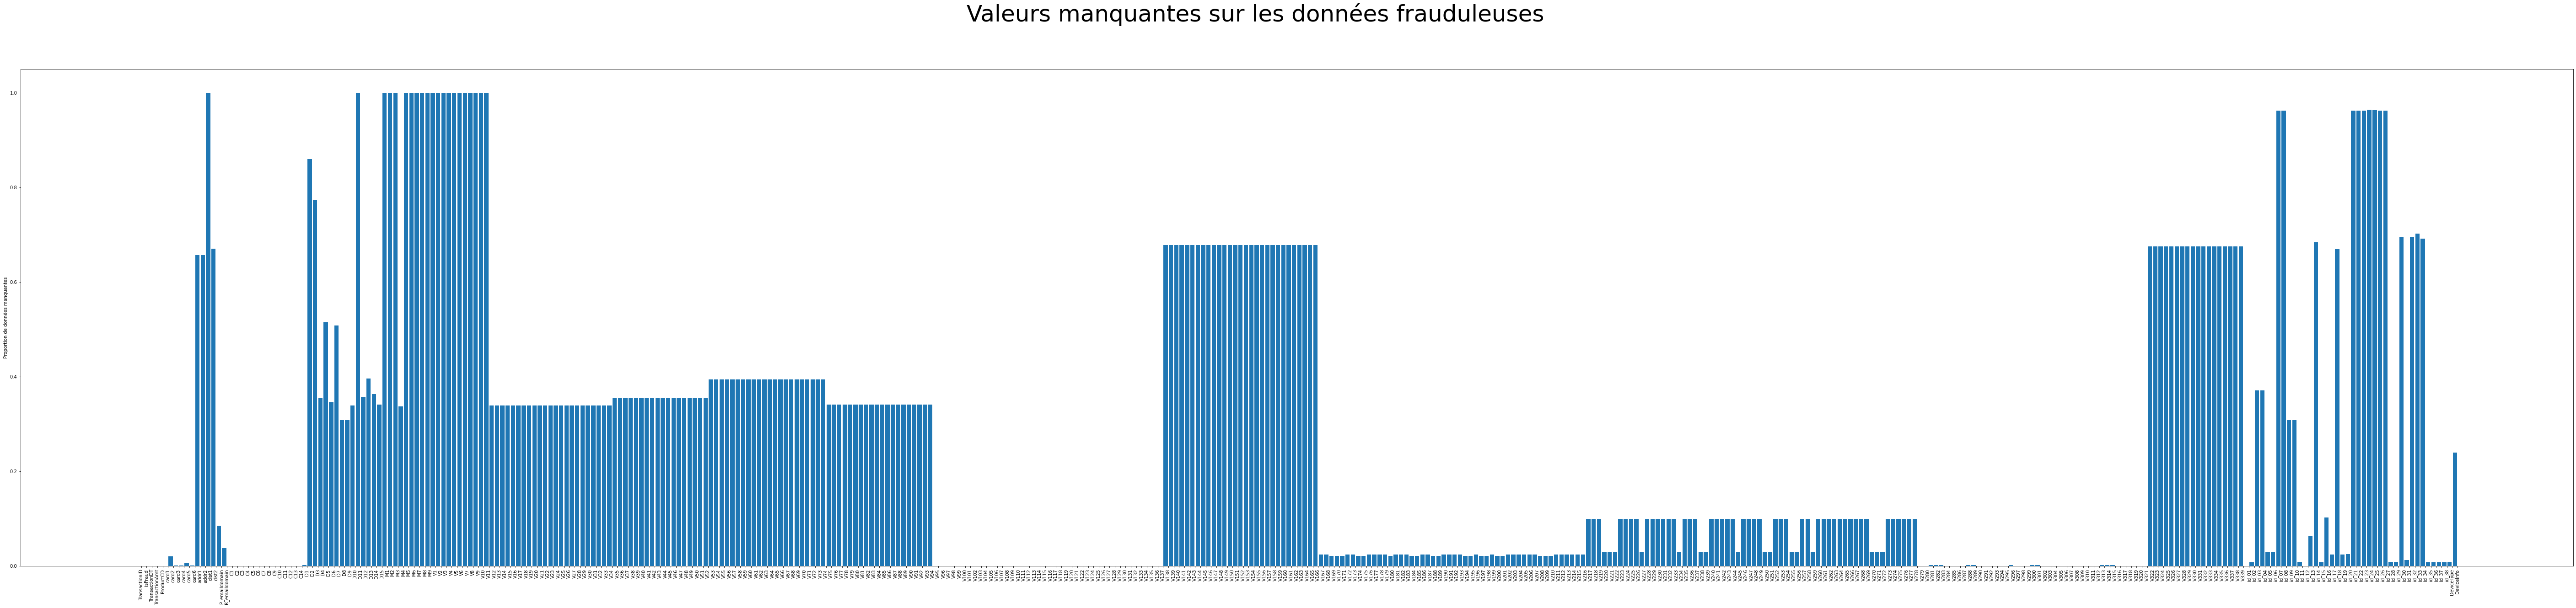

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 1])
plt.suptitle("Valeurs manquantes sur les données frauduleuses", fontsize=50)

Text(0.5, 0.98, 'Valeurs manquantes sur les données non frauduleuses')

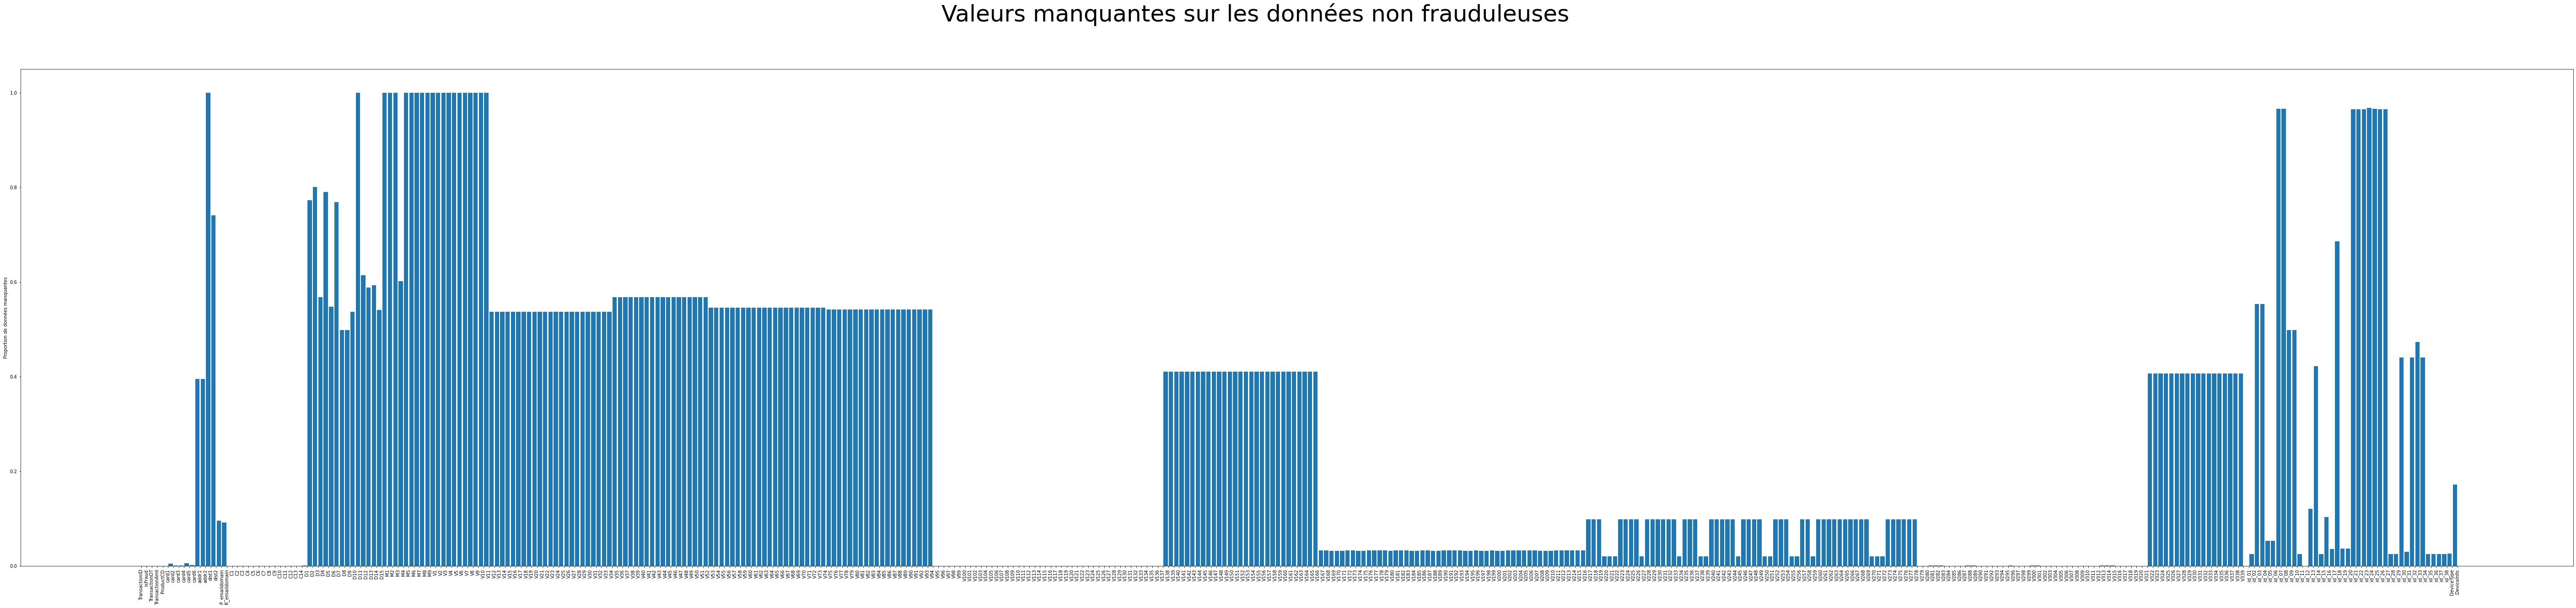

In [ ]:
missing_view(train_calibrate[train_calibrate.isFraud == 0])
plt.suptitle("Valeurs manquantes sur les données non frauduleuses", fontsize=50)

De manière générale, on remarque que la représentation est pratiquement la même. On peut dès lors faire une courbe de sensibilité pour voir le nombre de variables par seuil.

**Courbe de sensibilité**

In [ ]:
train_column_miss = train_calibrate.isnull().any()
print(f'Nombre de variables avec des données manquantes (apprentissage) : {train_column_miss.sum()} .')

Nombre de variables avec des données manquantes (apprentissage) : 412 .


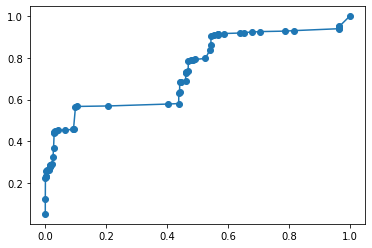

In [ ]:
column_miss = train_calibrate.isnull().sum()/train_calibrate.shape[0]
my_series = pd.Series(np.sort(column_miss.values))
sensibility_graph = my_series.value_counts().reset_index().sort_values(by=['index'])
sensibility_graph[0] = np.cumsum(sensibility_graph[0]/sensibility_graph[0].sum())
plt.plot(sensibility_graph['index'], sensibility_graph[0], '-o')

On peut essayer de voir ce qui se passe à partir de 60 % de données manquantes.

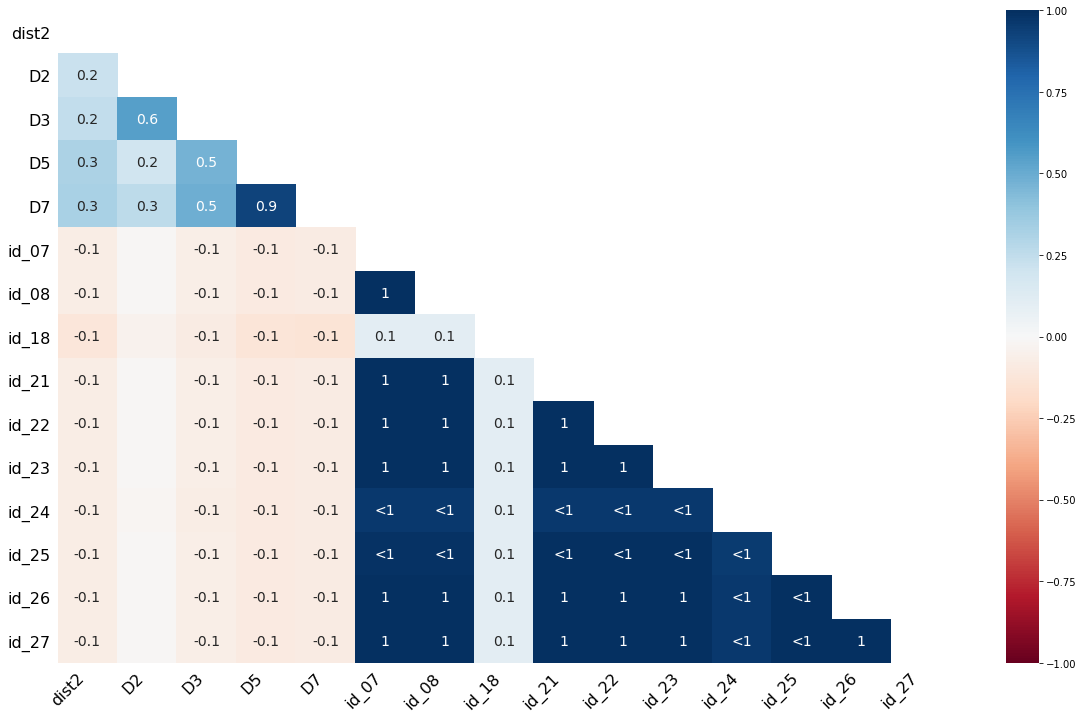

In [ ]:
null_counts = train_calibrate.isnull().sum()/len(train_calibrate)
train_data_miss_60 = train_calibrate.filter(items=null_counts[null_counts>=0.6].reset_index()['index'])
msno.heatmap(train_data_miss_60)

On remarque que pour plusieurs des variables, elles prennent conjointement les valeurs manquantes. Couplé au fait que l'apparition des données manquantes est relativement indépendant du caractère frauduleux de la variable, on peut se restreindre aux variables de moins de 60% de valeurs manquantes. De plus, la courbe de sensibilité nous incite à abaisser ce taux à 20% puisqu'il n'y a pas énormément de variables entre 20 et 40%. Une analyse comparative des résultats pourra être ajoutée suivant le seuil choisi.

**Traitement des valeurs manquantes**

In [ ]:
###On décide de ne retenir que les variables de moins de 20% de données manquantes et de procéder à une imputation par KNN 
train_work = train_calibrate.filter(items=null_counts[null_counts<0.2].reset_index()['index'])
train_work.shape

(22636, 246)

In [ ]:
from sklearn.impute import KNNImputer
train_imputed = KNNImputer(missing_values=np.nan, n_neighbors=5).fit_transform(train_work.select_dtypes(exclude='object'))

In [ ]:
train_imputed

array([[2.9870040e+06, 0.0000000e+00, 8.6506000e+04, ..., 1.6600000e+02,
        5.4200000e+02, 1.4400000e+02],
       [2.9872400e+06, 1.0000000e+00, 9.0193000e+04, ..., 2.2500000e+02,
        2.6600000e+02, 3.2500000e+02],
       [2.9872430e+06, 1.0000000e+00, 9.0246000e+04, ..., 2.2500000e+02,
        2.6600000e+02, 3.2500000e+02],
       ...,
       [3.5774510e+06, 0.0000000e+00, 1.5809554e+07, ..., 1.6600000e+02,
        3.1700000e+02, 2.2200000e+02],
       [3.5775060e+06, 0.0000000e+00, 1.5810402e+07, ..., 1.6600000e+02,
        5.2900000e+02, 2.2200000e+02],
       [3.5775260e+06, 1.0000000e+00, 1.5810876e+07, ..., 1.6600000e+02,
        3.5200000e+02, 3.3300000e+02]])

In [ ]:
train_imputed = pd.DataFrame(train_imputed)
train_imputed.columns = train_work.select_dtypes(exclude='object').columns
train_imputed = pd.merge(train_imputed,train_work[np.append('TransactionID',train_work.select_dtypes('object').columns.values)],on="TransactionID",how="left")
train_imputed


,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,...,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,id_01,id_02,id_05,id_06,id_11,id_13,id_17,id_19,id_20,ProductCD,card4,card6,P_emaildomain,R_emaildomain,id_12,id_15,id_16,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType
0,2987004.0,0.0,86506.0,50.000,4497.0,514.0,150.0,102.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,70787.0,0.4,-2.6,100.0,46.4,166.0,542.0,144.0,H,mastercard,credit,gmail.com,NaN,NotFound,New,NotFound,New,NotFound,samsung browser 6.2,T,F,T,T,mobile
1,2987240.0,1.0,90193.0,37.098,13413.0,103.0,185.0,137.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,169947.0,3.0,0.0,100.0,21.8,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
2,2987243.0,1.0,90246.0,37.098,13413.0,103.0,185.0,137.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,222455.0,0.0,0.0,100.0,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
3,2987245.0,1.0,90295.0,37.098,13413.0,103.0,185.0,137.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,271870.0,3.0,0.0,100.0,43.0,225.0,266.0,325.0,C,visa,credit,hotmail.com,hotmail.com,NotFound,Found,Found,Found,Found,chrome 54.0 for android,F,F,T,T,mobile
4,2987287.0,0.0,90973.0,25.014,7794.0,266.0,185.0,102.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,170760.0,0.0,0.0,100.0,25.6,225.0,266.0,507.0,C,mastercard,credit,gmail.com,gmail.com,NotFound,New,NotFound,New,NotFound,safari generic,F,F,T,T,desktop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22631,3577364.0,1.0,15807516.0,69.964,5812.0,408.0,185.0,224.0,1.0,3.0,0.0,1.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,2.0,0.0,0.0,112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,48.0774,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,48.0774,0.0,0.0,0.0,0.0,-5.0,183132.0,0.0,0.0,100.0,27.0,225.0,266.0,315.0,C,mastercard,debit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,samsung browser 6.4,F,F,T,F,mobile
22632,3577368.0,1.0,15807677.0,100.000,6758.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,-5.0,214747.0,0.0,0.0,100.0,27.0,166.0,492.0,225.0,H,american express,credit,hotmail.com,hotmail.com,NotFound,New,NotFound,New,NotFound,mobile safari 11.0,T,F,F,T,mobile
22633,3577451.0,0.0,15809554.0,200.000,16434.0,399.0,150.0,146.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,4.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.

**categorical features**

C    12250
R     4512
H     4231
S     1643
Name: ProductCD, dtype: int64


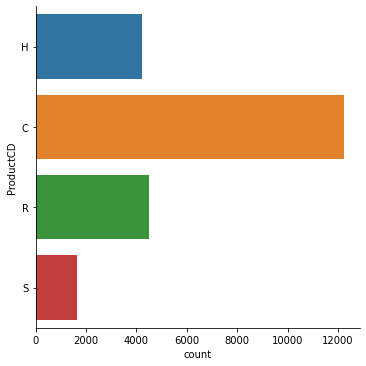

In [ ]:
print(train_imputed['ProductCD'].value_counts(dropna=False))
sns.catplot(y='ProductCD',kind='count',data=train_imputed)
  

visa                14028
mastercard           7248
american express      958
discover              369
NaN                    33
Name: card4, dtype: int64


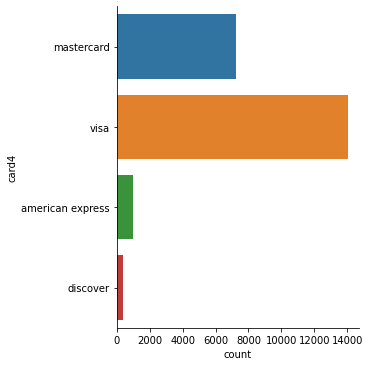

In [ ]:
print(train_imputed['card4'].value_counts(dropna=False))
sns.catplot(y='card4',kind='count',data=train_imputed)

credit         12515
debit          10087
NaN               33
charge card        1
Name: card6, dtype: int64


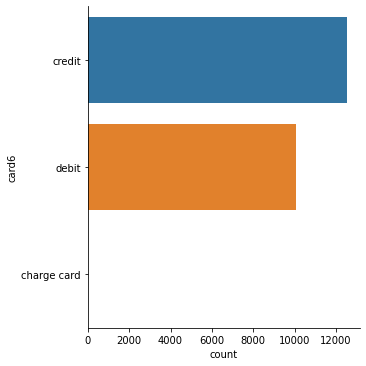

In [ ]:
print(train_imputed['card6'].value_counts(dropna=False))
sns.catplot(y='card6',kind='count',data=train_imputed)

gmail.com           10308
hotmail.com          4122
anonymous.com        2086
NaN                  2042
yahoo.com            1410
outlook.com           585
aol.com               444
comcast.net           226
icloud.com            170
yahoo.com.mx          118
msn.com               108
verizon.net            81
outlook.es             80
live.com.mx            80
live.com               76
bellsouth.net          58
sbcglobal.net          58
me.com                 56
att.net                49
mail.com               46
cox.net                42
hotmail.es             33
mac.com                32
ymail.com              31
optonline.net          30
protonmail.com         29
charter.net            28
hotmail.fr             22
yahoo.fr               19
web.de                 18
gmail                  12
prodigy.net.mx         11
earthlink.net          10
hotmail.co.uk          10
yahoo.es                9
yahoo.de                9
rocketmail.com          8
suddenlink.net          8
live.fr     

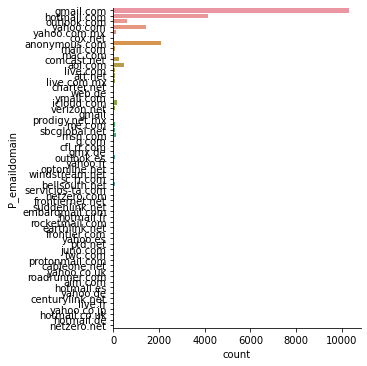

In [ ]:
print(train_imputed['P_emaildomain'].value_counts(dropna=False))
sns.catplot(y='P_emaildomain',kind='count',data=train_imputed)

gmail.com           10726
hotmail.com          4074
anonymous.com        2222
yahoo.com            1578
NaN                  1470
outlook.com           580
aol.com               431
icloud.com            289
comcast.net           176
yahoo.com.mx          118
live.com.mx            85
live.com               83
outlook.es             80
msn.com                73
me.com                 54
mail.com               52
sbcglobal.net          46
cox.net                45
verizon.net            41
protonmail.com         40
bellsouth.net          38
hotmail.es             33
att.net                33
hotmail.fr             22
ymail.com              21
yahoo.fr               21
mac.com                20
charter.net            20
web.de                 18
prodigy.net.mx         11
rocketmail.com         11
gmail                  11
optonline.net          10
hotmail.co.uk          10
yahoo.de                9
yahoo.es                8
live.fr                 7
gmx.de                  7
earthlink.ne

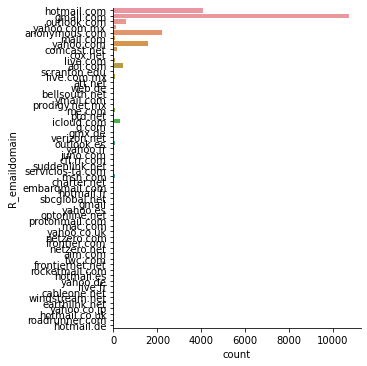

In [ ]:
print(train_imputed['R_emaildomain'].value_counts(dropna=False))
sns.catplot(y='R_emaildomain',kind='count',data=train_imputed)

NotFound    19652
Found        2984
Name: id_12, dtype: int64


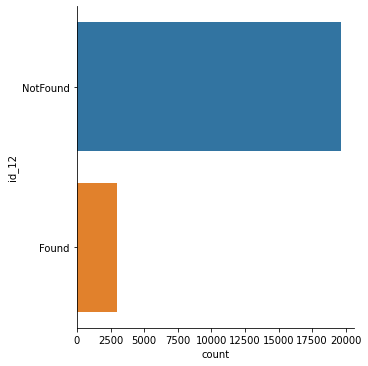

In [ ]:
print(train_imputed['id_12'].value_counts(dropna=False))
sns.catplot(y='id_12',kind='count',data=train_imputed)

Found      12275
New         8021
Unknown     1960
NaN          380
Name: id_15, dtype: int64


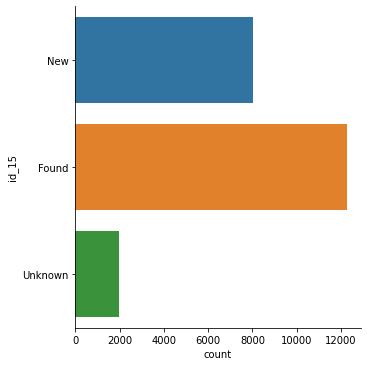

In [ ]:
print(train_imputed['id_15'].value_counts(dropna=False))
sns.catplot(y='id_15',kind='count',data=train_imputed)

Found       12159
NotFound     8137
NaN          2340
Name: id_16, dtype: int64


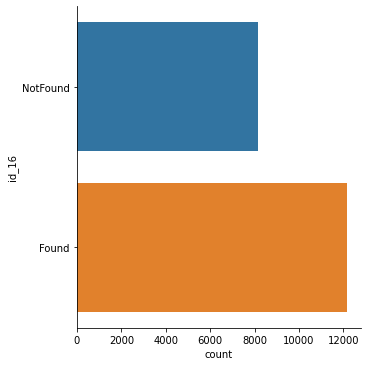

In [ ]:
print(train_imputed['id_16'].value_counts(dropna=False))
sns.catplot(y='id_16',kind='count',data=train_imputed)

Found    13612
New       8640
NaN        384
Name: id_28, dtype: int64


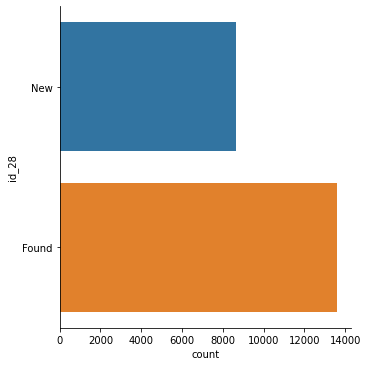

In [ ]:
print(train_imputed['id_28'].value_counts(dropna=False))
sns.catplot(y='id_28',kind='count',data=train_imputed)

Found       13501
NotFound     8751
NaN           384
Name: id_29, dtype: int64


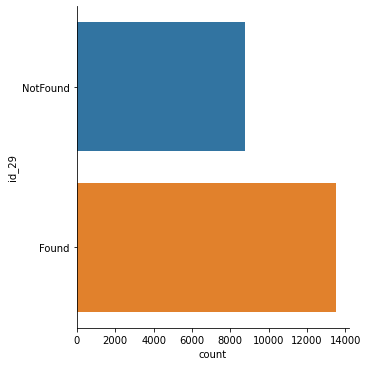

In [ ]:
print(train_imputed['id_29'].value_counts(dropna=False))
sns.catplot(y='id_29',kind='count',data=train_imputed)

chrome 63.0                       3303
mobile safari generic             2064
mobile safari 11.0                1919
chrome 65.0                       1211
chrome 64.0                       1137
chrome generic                    1129
chrome 63.0 for android           1081
ie 11.0 for desktop                934
chrome 62.0                        888
safari generic                     875
chrome 64.0 for android            800
chrome 66.0                        733
chrome 65.0 for android            704
NaN                                485
chrome 66.0 for android            482
firefox 57.0                       456
edge 16.0                          447
mobile safari 10.0                 337
chrome 62.0 for android            334
chrome generic for android         199
firefox                            192
edge 15.0                          188
firefox 59.0                       173
samsung browser 6.2                156
firefox 58.0                       144
chrome 61.0 for android  

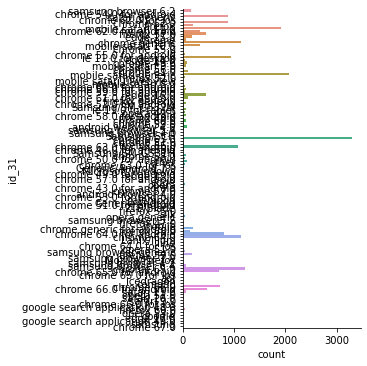

In [ ]:
print(train_imputed['id_31'].value_counts(dropna=False))
sns.catplot(y='id_31',kind='count',data=train_imputed)

F      12427
T       9829
NaN      380
Name: id_35, dtype: int64


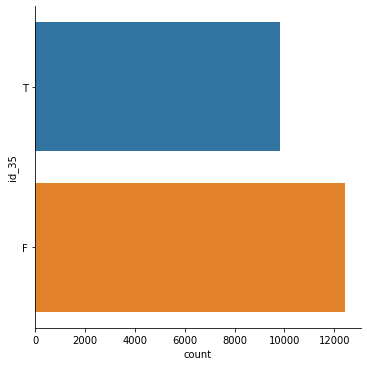

In [ ]:
print(train_imputed['id_35'].value_counts(dropna=False))
sns.catplot(y='id_35',kind='count',data=train_imputed)

F      21444
T        812
NaN      380
Name: id_36, dtype: int64


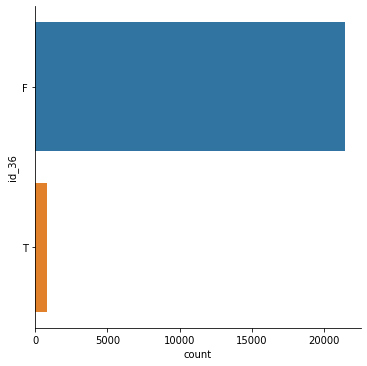

In [ ]:
print(train_imputed['id_36'].value_counts(dropna=False))
sns.catplot(y='id_36',kind='count',data=train_imputed)

T      17821
F       4435
NaN      380
Name: id_37, dtype: int64


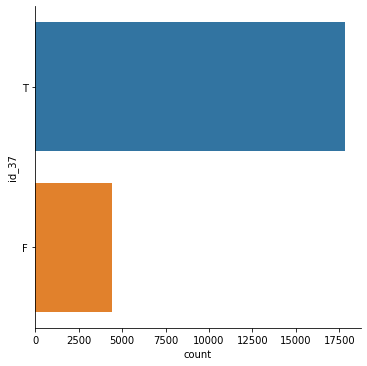

In [ ]:
print(train_imputed['id_37'].value_counts(dropna=False))
sns.catplot(y='id_37',kind='count',data=train_imputed)

F      12856
T       9400
NaN      380
Name: id_38, dtype: int64


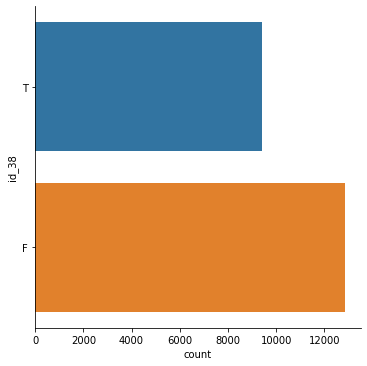

In [ ]:
print(train_imputed['id_38'].value_counts(dropna=False))
sns.catplot(y='id_38',kind='count',data=train_imputed)

desktop    12351
mobile      9882
NaN          403
Name: DeviceType, dtype: int64


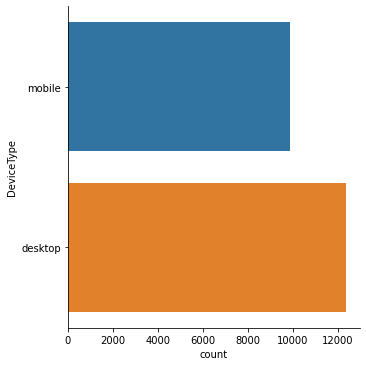

In [ ]:
print(train_imputed['DeviceType'].value_counts(dropna=False))
sns.catplot(y='DeviceType',kind='count',data=train_imputed)

**Logistic Regression avec les features numerique**

In [ ]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train1=train_imputed.drop(['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType'],axis=1)
Y_train=train1['isFraud'].astype('int')
X_train=train1.drop('isFraud',axis=1)
scaler=preprocessing.StandardScaler()
X_train_st=scaler.fit_transform(X_train)


In [ ]:
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8490522914315324

**Feature importance**

Feature: TransactionID Score: 4.97600
Feature: TransactionDT Score: -4.60213
Feature: TransactionAmt Score: 0.44443
Feature: card1 Score: -0.12187
Feature: card2 Score: -0.16228
Feature: card3 Score: 0.32858
Feature: card5 Score: -0.02455
Feature: C1 Score: -2.47759
Feature: C2 Score: 2.45171
Feature: C3 Score: -0.41121
Feature: C4 Score: 1.58524
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.51616
Feature: C7 Score: -4.44784
Feature: C8 Score: 4.25714
Feature: C9 Score: 0.00000
Feature: C10 Score: 3.47256
Feature: C11 Score: 5.37544
Feature: C12 Score: -1.28605
Feature: C13 Score: -3.09151
Feature: C14 Score: -6.50628
Feature: D1 Score: -0.24726
Feature: V95 Score: 0.35177
Feature: V96 Score: 0.08786
Feature: V97 Score: -0.07631
Feature: V98 Score: 0.05909
Feature: V99 Score: 0.61891
Feature: V100 Score: -0.01133
Feature: V101 Score: 0.46920
Feature: V102 Score: 0.29882
Feature: V103 Score: 0.01287
Feature: V104 Score: 0.15393
Feature: V105 Score: -1.65434
Feature: V106 Score: 0.0756

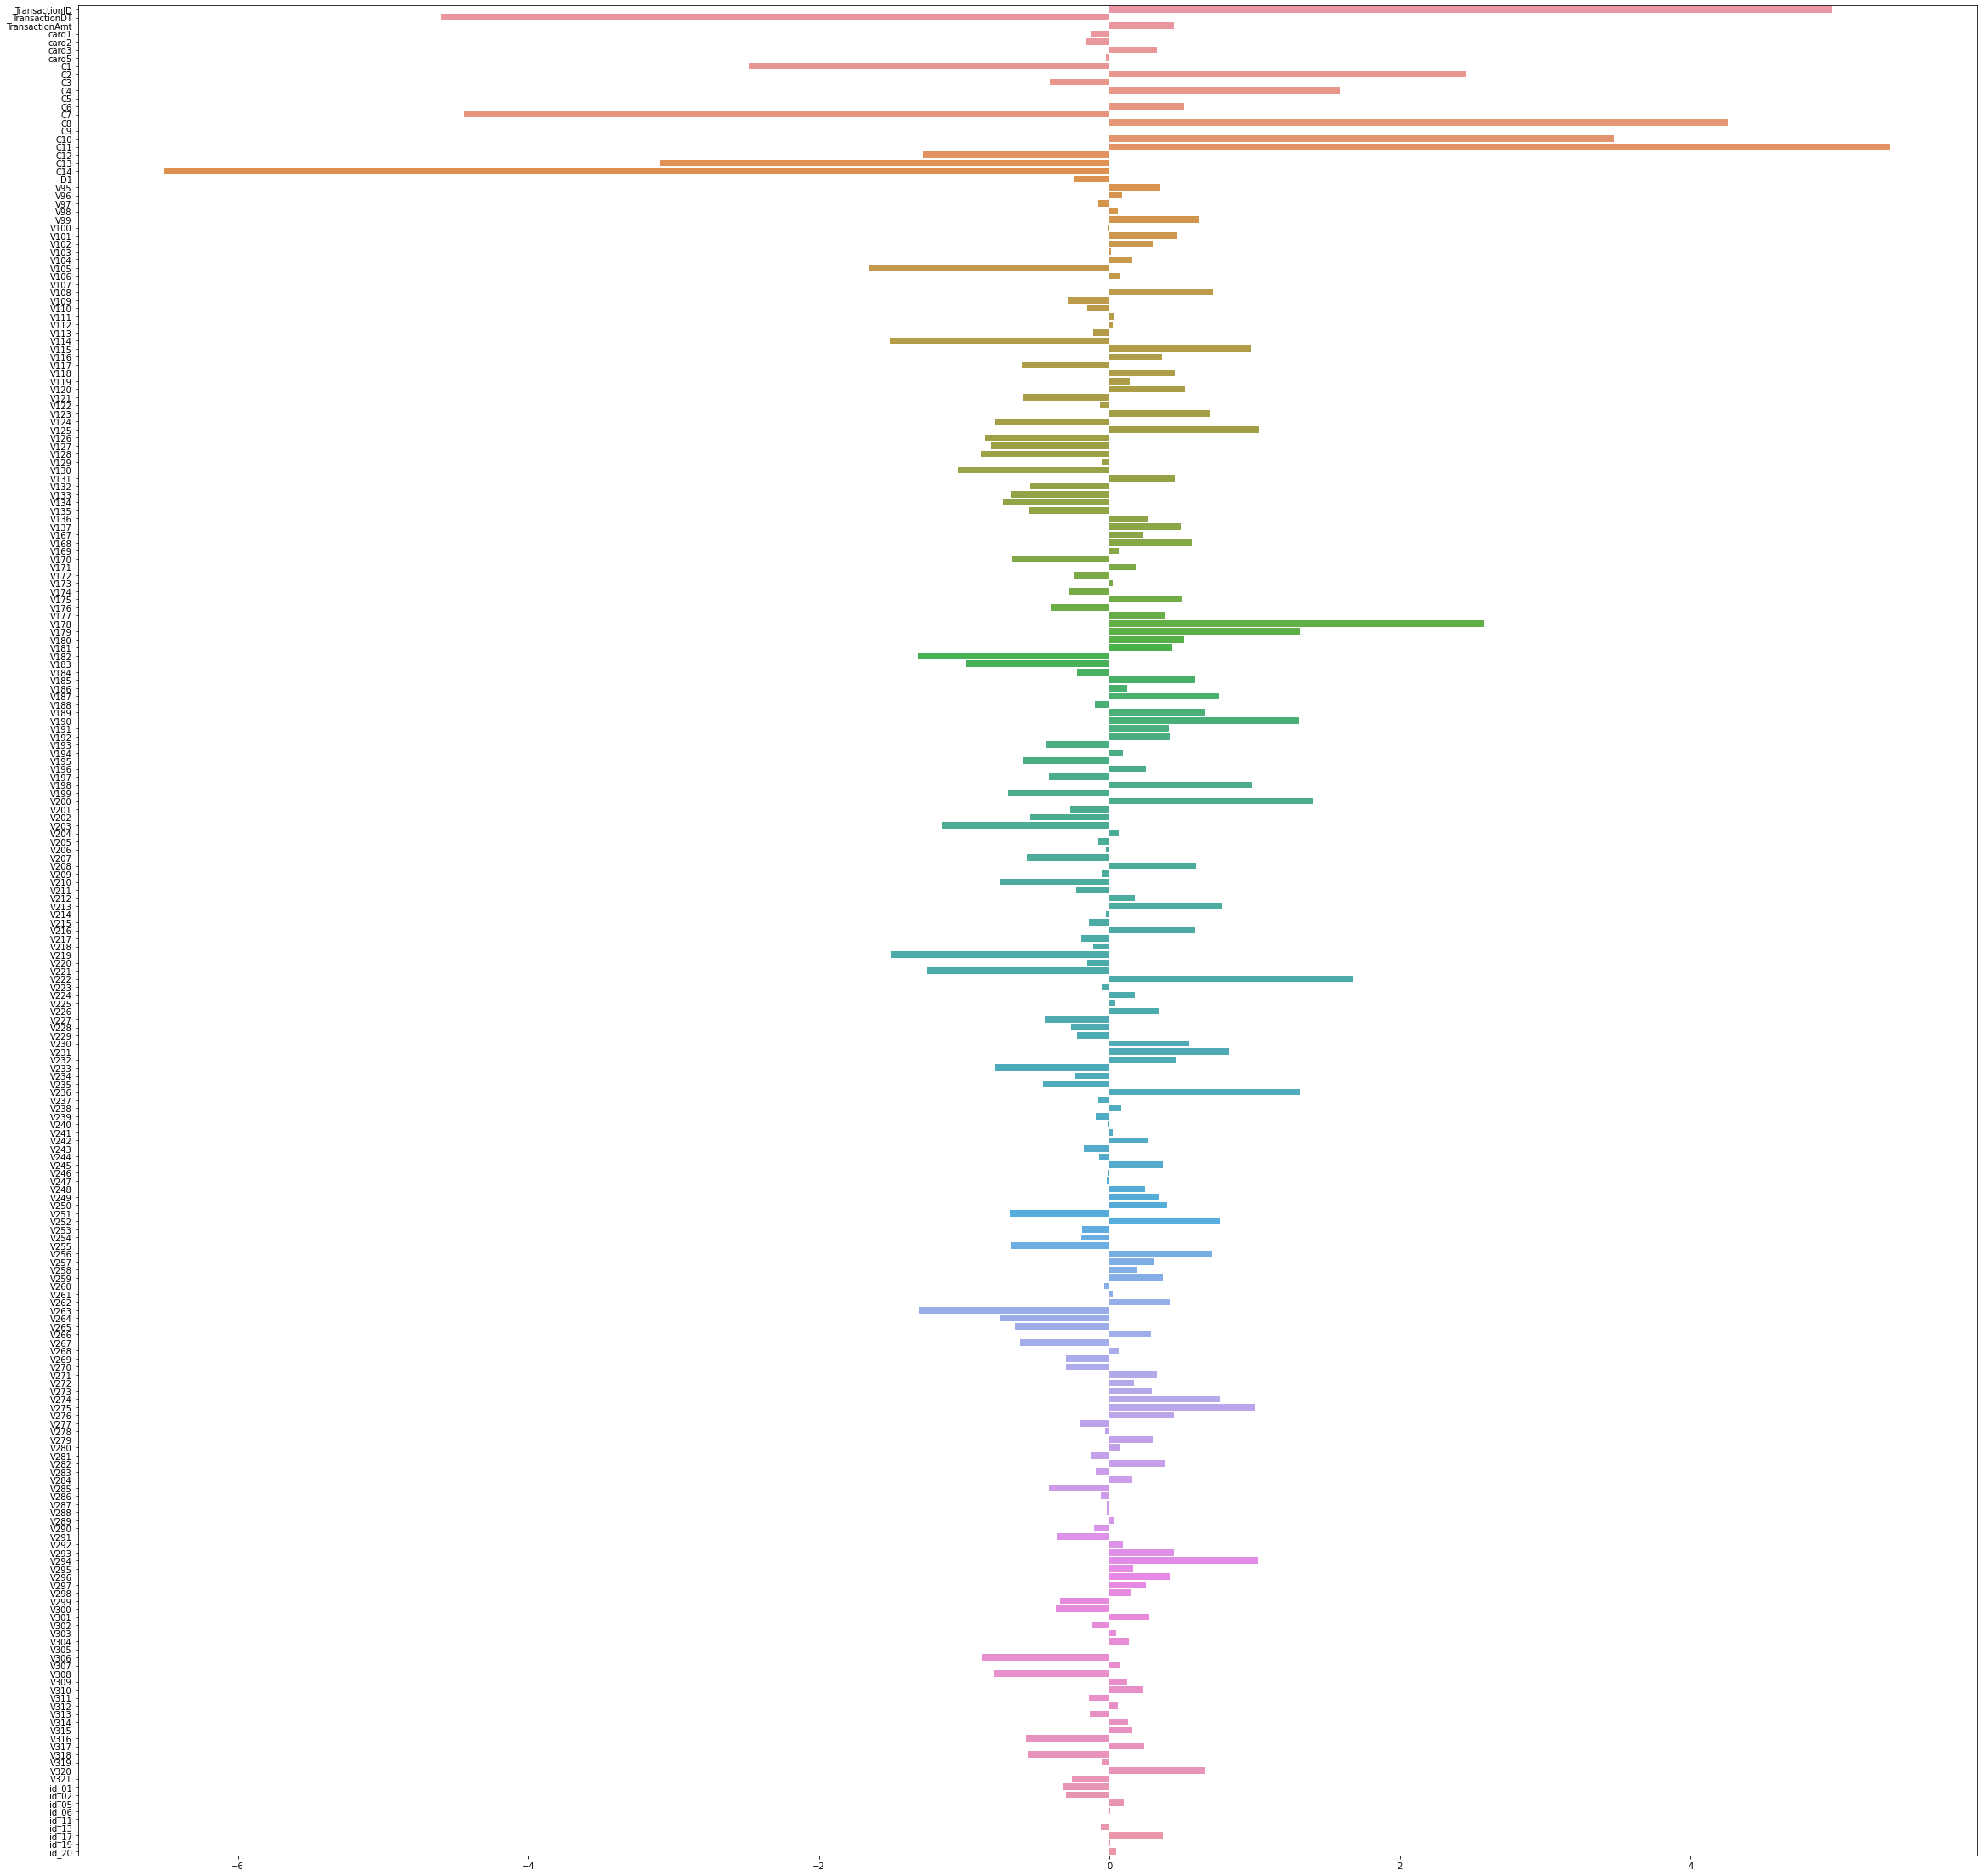

In [ ]:
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [ ]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="f1")
rfecv.fit(X_train_st,Y_train)
rfecv.transform(X_train_st)

array([[-1.58665963, -1.43950221, -0.3483706 , ...,  0.72843132,
        -0.70341821, -0.98580368],
       [-1.58530243, -1.43871799, -0.47180963, ...,  0.72843132,
        -0.10490677,  0.92829991],
       [-1.58528517, -1.43870671, -0.47180963, ...,  0.72843132,
         0.21202182,  0.92829991],
       ...,
       [ 1.80891354,  1.90477033,  1.08674447, ..., -0.6886606 ,
        -0.34274203, -0.98580368],
       [ 1.80922984,  1.9049507 ,  1.08674447, ...,  0.72843132,
        -0.63212316, -0.98580368],
       [ 1.80934485,  1.90505151,  1.56511615, ...,  0.44501294,
        -0.09215913, -0.98580368]])

In [ ]:
rfecv.n_features_#Number of best features

144

In [ ]:
rfecv.ranking_

array([ 1,  1,  1, 13,  1,  1, 59,  1,  1,  1,  1, 84,  1,  1,  1, 83,  1,
        1,  1,  1,  1,  1,  1, 47, 16, 35,  1, 22,  1,  1, 79, 33,  1,  1,
       85,  1,  1, 24, 58, 52, 14,  1,  1,  1,  1,  1, 38,  1,  1, 37,  1,
        1,  1,  1,  1,  1, 76,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 43,
        1, 50,  7, 69,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 53,
        1, 49,  1,  1,  1,  1,  1, 21,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 55, 68,  1,  1, 57,  1,  5, 56,  1, 34, 17,  1,  1, 44,  1, 15,
        1,  1, 74,  1, 71,  1,  1,  1,  1,  1,  1,  1,  1,  1, 28,  1, 46,
       26, 23, 63, 64,  1,  1, 65,  1, 70, 42, 27,  1,  1,  1,  1, 41, 12,
        1,  1, 25,  1,  1,  1, 45,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       31,  1,  1,  1,  1, 51, 75, 30, 60,  1,  1, 54,  1,  1, 39, 81, 62,
       67, 32,  1, 78,  1,  1, 29, 11,  4,  1,  8,  1,  1,  9, 61, 10, 86,
        1, 48,  1, 66,  1,  1, 73, 18,  1, 19,  1,  6,  1, 72,  2,  3,  1,
        1, 20, 80, 82, 36

In [ ]:
rfecv.support_#which features to keep 

array([ True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
       False,  True,  True, False, False,  True,  True, False,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
        True, False, False,  True, False, False,  True,  True, False,
        True, False,  True,  True, False,  True, False,  True,  True,
        True,  True,

In [ ]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train.columns)[i])
X_train1=X_train.drop(pp,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st1=scaler.fit_transform(X_train1)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

0.8593229267036367

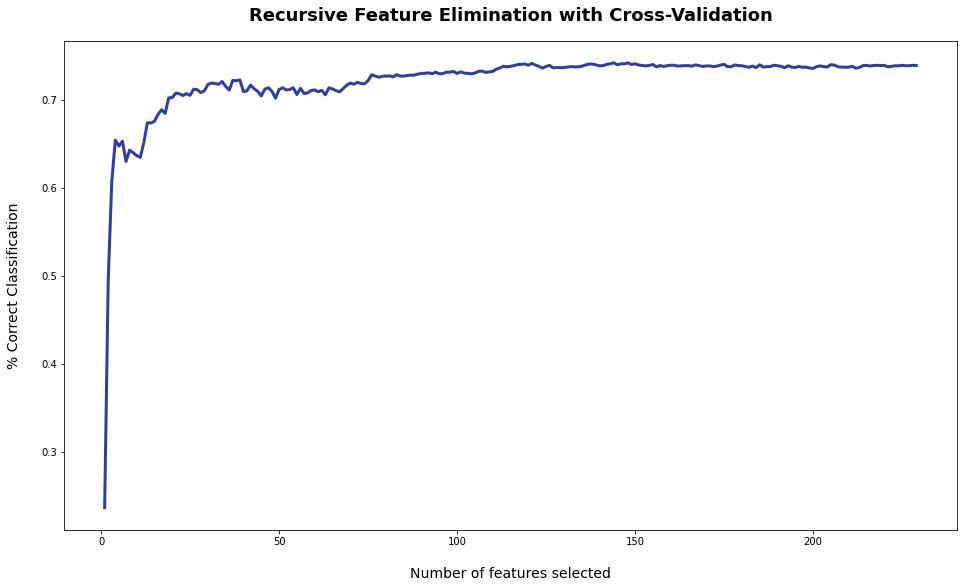

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

**best 35 features**

Since crossvalidation is a random process and we can get different outputs for different imputations we fix a nombre of features to always take. From the graph below we can see that ~35 features is good enough.

In [ ]:
dictionnaire={}
best_35_features=[]
features_to_take=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==True:
    features_to_take.append(i)
logit.fit(X_train_st,Y_train)
importance = logit.coef_[0]
#summarize feature importance
for i,v in enumerate(importance):
  if i in features_to_take:
    dictionnaire[i]= abs(v)
sortedDict = sorted(dictionnaire.items(), key=lambda x: x[1])
for j in range(1,36):
  best_35_features.append(sortedDict[-j][0])
for k in range(len(best_35_features)):
  best_35_features[k]=list(X_train.columns)[best_35_features[k]]
best_35_features


['C14',
 'C11',
 'TransactionID',
 'TransactionDT',
 'C7',
 'C8',
 'C10',
 'C13',
 'V178',
 'C1',
 'C2',
 'V222',
 'V105',
 'C4',
 'V114',
 'V219',
 'V200',
 'V182',
 'V263',
 'V236',
 'V179',
 'V190',
 'C12',
 'V221',
 'V203',
 'V130',
 'V125',
 'V294',
 'V275',
 'V183',
 'V198',
 'V115',
 'V128',
 'V306',
 'V126']

**Removing irrelevant features**

In [ ]:
#il faut q'on fixe un thresh hold q
l1=[]#liste des features sans imporatnace
for i in range(len(imp)):
  if imp[i]==0:
    l1.append(list(X_train.columns)[i])
X_train_q=X_train.drop(l1,axis=1)
scaler=preprocessing.StandardScaler()
X_train_st_q=scaler.fit_transform(X_train_q)
logit=LogisticRegression(C=31,random_state=42)
cv_scores = cross_val_score(logit, X_train_st_q, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score reste le meme

0.8491006184123531

**Logistic Regression avec toutes les features**

In [ ]:
sites = ['ProductCD','card4','card6','P_emaildomain','R_emaildomain', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_31', 'id_35', 'id_36', 'id_37','id_38','DeviceType']
train_1=train_imputed.drop(sites,axis=1)
Y_train=train_1['isFraud'].astype('int')
X_train=train_1.drop('isFraud',axis=1)
X_train_full=pd.merge(X_train,pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)
scaler=preprocessing.StandardScaler()
X_train_st_only_numerical=scaler.fit_transform(X_train)
X_train_full_st=pd.merge(pd.DataFrame(X_train_st_only_numerical),pd.get_dummies(train_imputed[sites]),right_index=True,left_index=True)

In [ ]:
logit=LogisticRegression(C=1,random_state=42)
cv_scores = cross_val_score(logit, X_train_full_st, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()

0.8505231872696453

**Feature importance**

Feature: TransactionID Score: 2.36771
Feature: TransactionDT Score: -1.97869
Feature: TransactionAmt Score: 0.65417
Feature: card1 Score: -0.09457
Feature: card2 Score: -0.17035
Feature: card3 Score: 0.34413
Feature: card5 Score: 0.00820
Feature: C1 Score: -2.13620
Feature: C2 Score: 2.14880
Feature: C3 Score: -0.55658
Feature: C4 Score: 1.00623
Feature: C5 Score: 0.00000
Feature: C6 Score: 0.79093
Feature: C7 Score: -2.79094
Feature: C8 Score: 2.76546
Feature: C9 Score: 0.00000
Feature: C10 Score: 1.84981
Feature: C11 Score: 3.55780
Feature: C12 Score: -0.47191
Feature: C13 Score: -2.51189
Feature: C14 Score: -4.21065
Feature: D1 Score: -0.23388
Feature: V95 Score: 0.14691
Feature: V96 Score: 0.12864
Feature: V97 Score: 0.00474
Feature: V98 Score: 0.09233
Feature: V99 Score: 0.53701
Feature: V100 Score: -0.18939
Feature: V101 Score: 0.21748
Feature: V102 Score: 0.24755
Feature: V103 Score: 0.07262
Feature: V104 Score: -0.08567
Feature: V105 Score: -0.91242
Feature: V106 Score: -0.1473

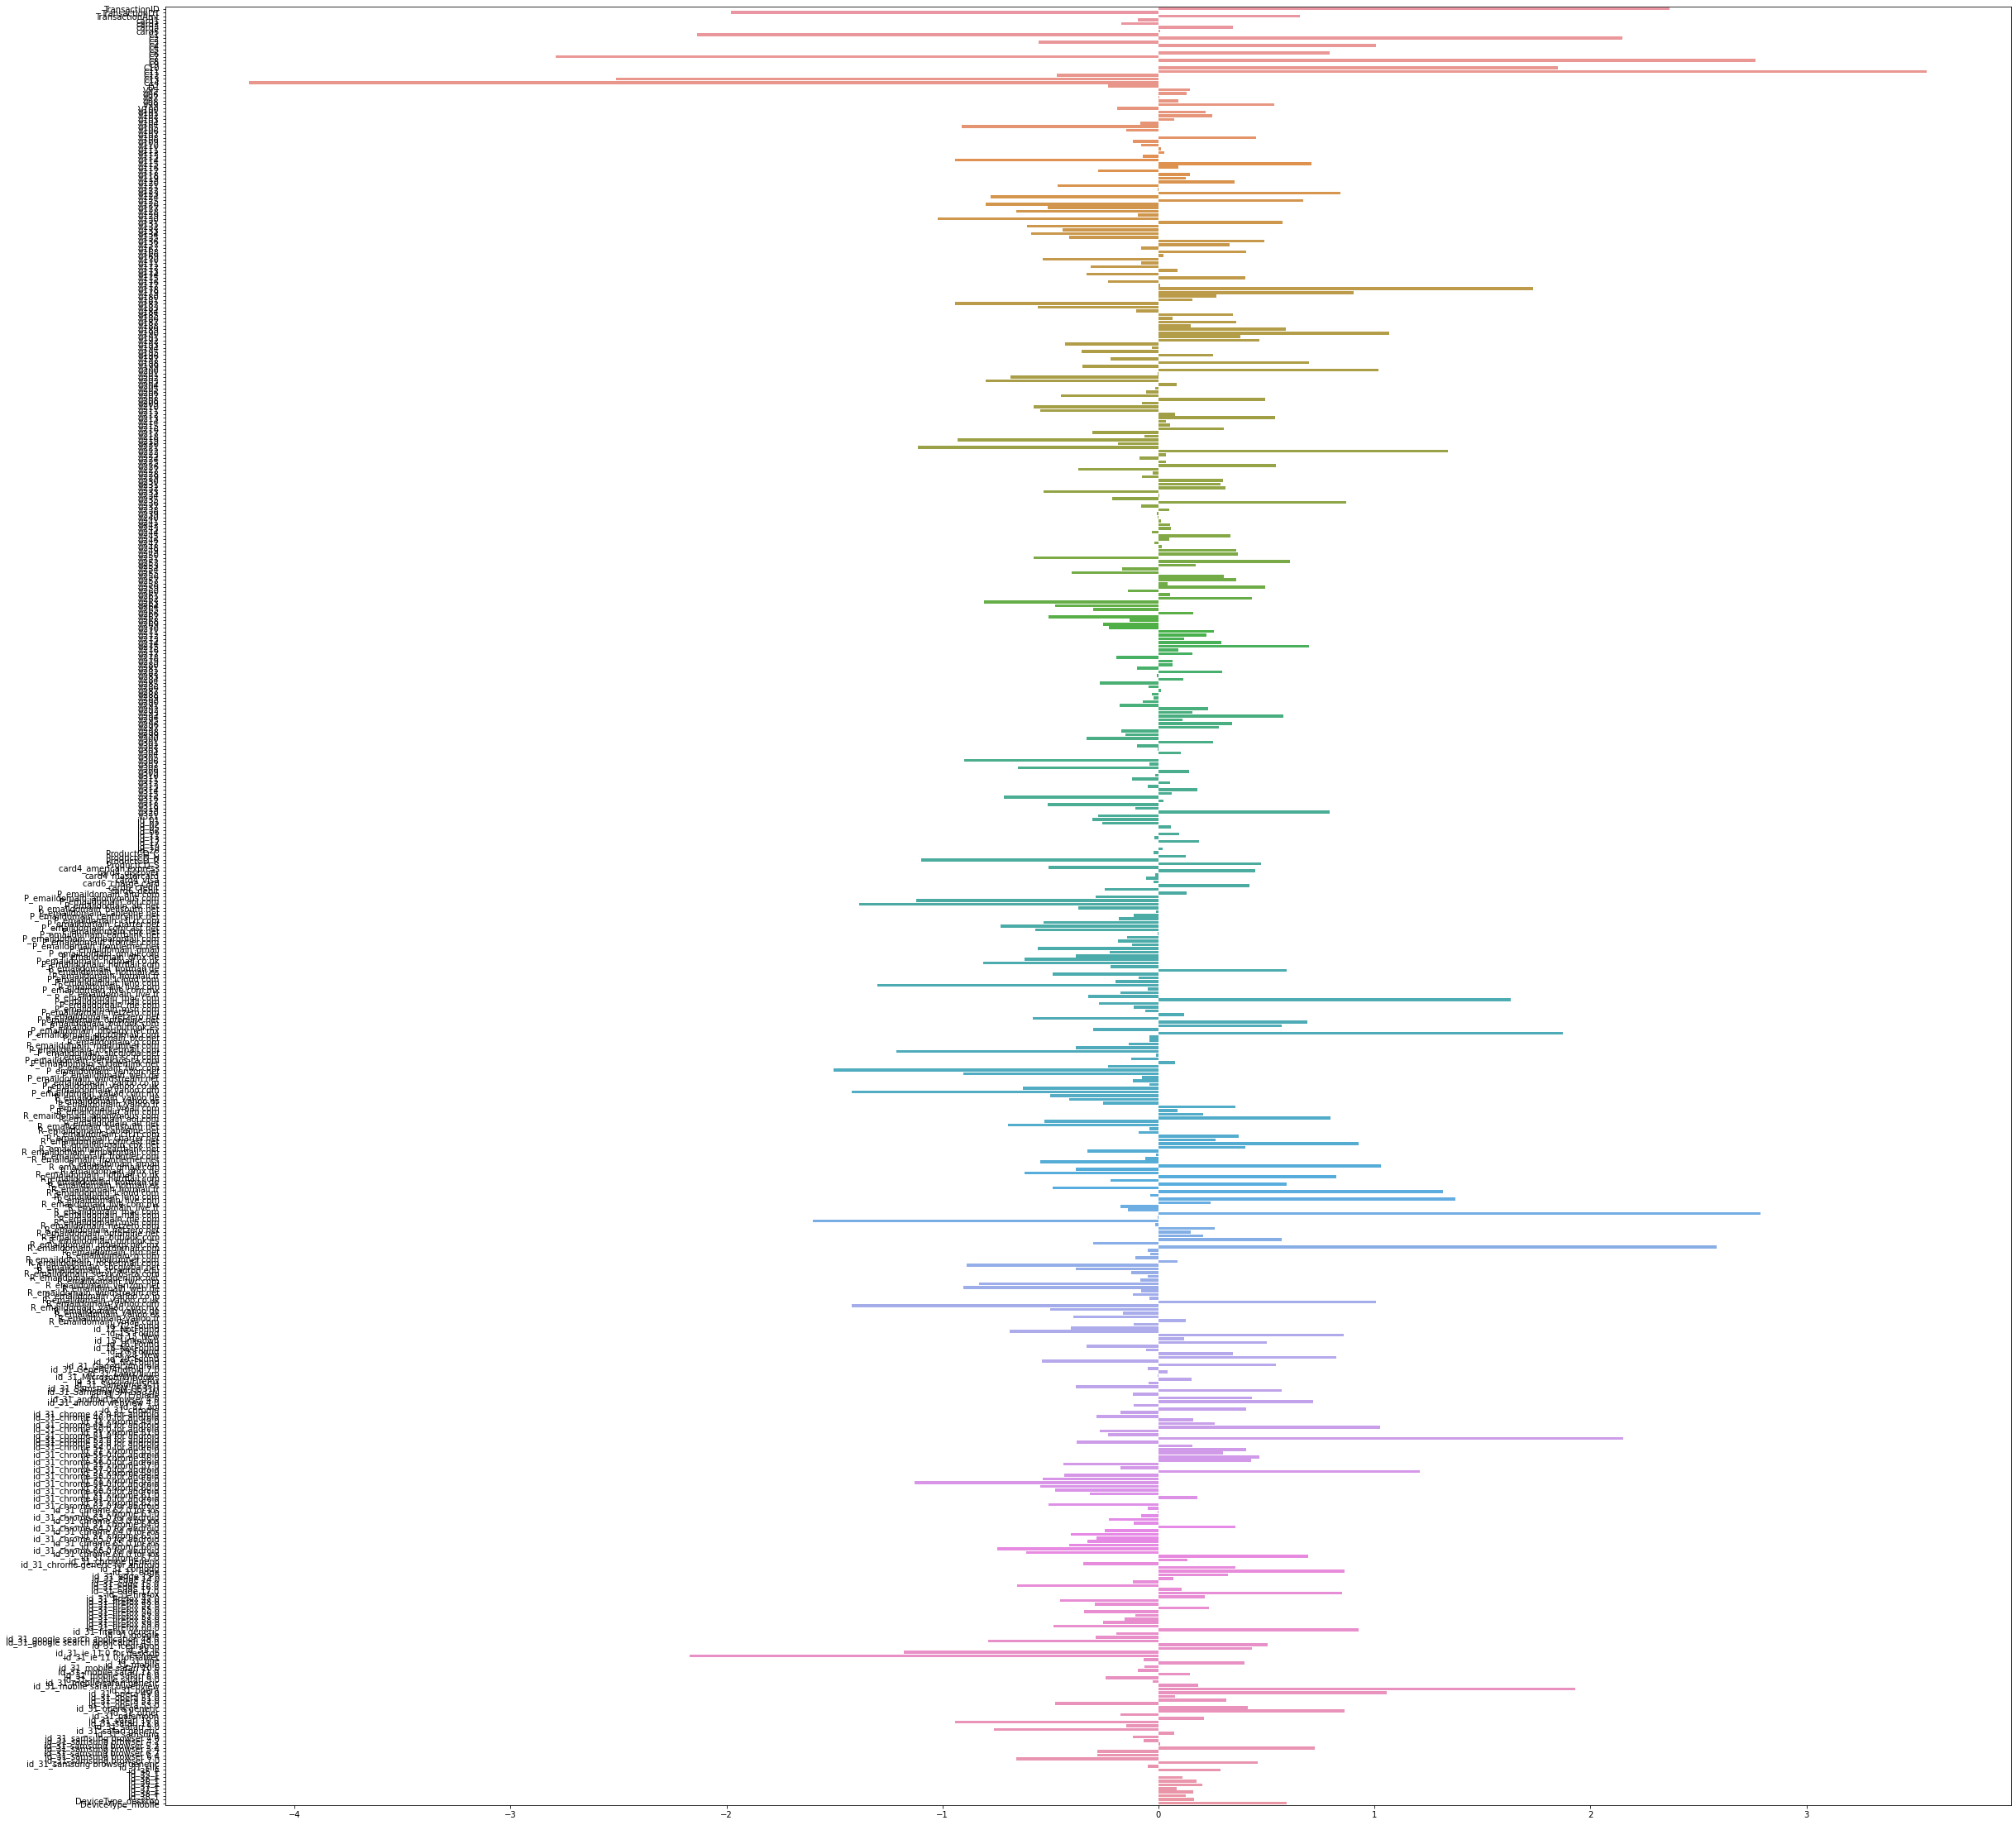

In [ ]:
logit.fit(X_train_full_st,Y_train)
importance = logit.coef_[0]
imp=np.zeros(len(importance))
#summarize feature importance
for i,v in enumerate(importance):
	print('Feature:',list(X_train_full.columns)[i],'Score: %.5f' % (v))
#plot feature importance
for i,v in enumerate(importance):
  imp[i]='%.5f' % (v)
fig_dims = (40, 40)
fig, ax = plt.subplots(figsize=fig_dims) 
ax = sns.barplot(x=imp, y=list(X_train_full.columns),ax=ax)

**recrusive feature elimination using cross validation (RFECV)**

In [ ]:
from sklearn.feature_selection import RFECV 
rfecv=RFECV(estimator=logit,step=1,scoring="f1")
rfecv.fit(X_train_full_st,Y_train)
rfecv.transform(X_train_full_st)

array([[-1.58665963, -1.43950221, -0.3483706 , ...,  1.        ,
         0.        ,  1.        ],
       [-1.58530243, -1.43871799, -0.47180963, ...,  1.        ,
         0.        ,  1.        ],
       [-1.58528517, -1.43870671, -0.47180963, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.80891354,  1.90477033,  1.08674447, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.80922984,  1.9049507 ,  1.08674447, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.80934485,  1.90505151,  1.56511615, ...,  0.        ,
         0.        ,  1.        ]])

In [ ]:
rfecv.n_features_

411

In [ ]:
rfecv.ranking_

array([ 1,  1,  1,  1,  1,  1, 73,  1,  1,  1,  1, 75,  1,  1,  1, 76,  1,
        1,  1,  1,  1,  1,  1,  1, 70,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       78,  1,  1, 18, 37, 27,  1,  1,  1,  1,  1,  1,  1,  1,  1, 23,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 50,
        1, 45,  1,  1,  1,  1,  1, 52,  1,  1,  1,  1,  1,  1,  4,  1, 11,
        1,  1,  1,  1,  1,  1,  1, 55,  1,  1,  1,  1,  1,  1, 53,  1,  1,
        1, 71,  1,  1,  1,  1,  1,  1, 20,  1, 24,  1,  1,  1,  1,  1,  1,
        1,  1, 54,  1,  1,  1,  1, 43, 38,  1,  1,  1,  1, 66,  1,  1, 25,
       58, 65, 61, 64,  1, 17, 69,  1, 49, 60, 42,  1,  1,  1,  1,  1,  1,
        1,  1,  1, 12,  1,  1,  1,  1,  1,  1,  1,  1,  1, 22,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, 26,  1,  1,  1, 56,  1,  1,  1, 62, 41,
        1, 40, 39,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 63,  1, 77,
        1,  1,  1,  1,  1,  1, 10,  1,  1,  1,  1, 44,  1,  1,  1,  1,  1,
        1,  1, 21,  1, 51

In [ ]:
rfecv.support_#which features to keep 

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False, False,

In [ ]:
pp=[]
for i in range(len(rfecv.support_)):
  if rfecv.support_[i]==False:
    pp.append(list(X_train_full_st.columns)[i])
X_train_full_st_1=X_train_full_st.drop(pp,axis=1)
logit=LogisticRegression(C=2,random_state=42)
cv_scores = cross_val_score(logit, X_train_full_st_1, Y_train, cv=5, scoring='roc_auc')
cv_scores.mean()#verification que le score augmente

0.8577434744257971

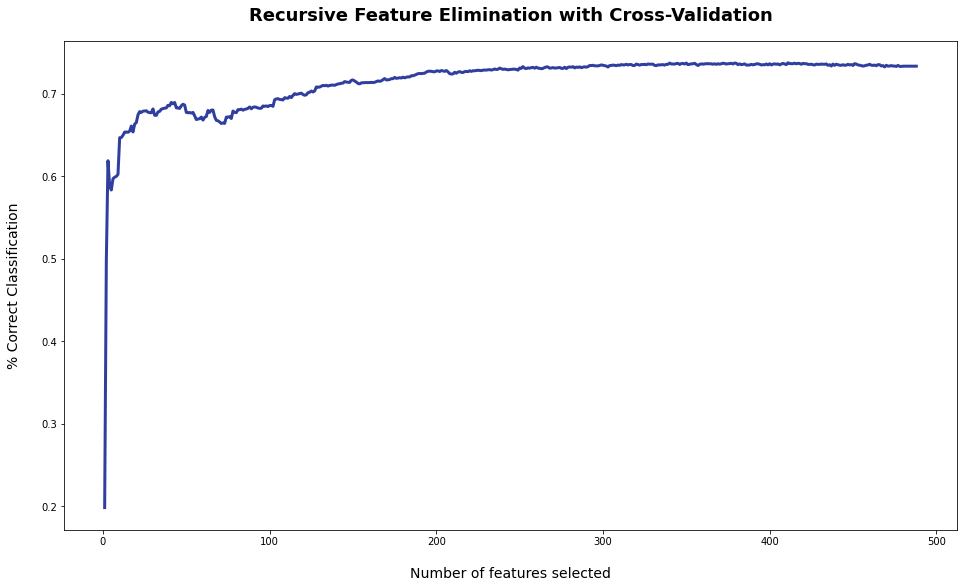

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

**SVM**

In [ ]:
from sklearn.svm import SVC 
 from sklearn.model_selection import GridSearchCV 
  
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train_full_st, y_train) 
print(grid.best_params_) 
